# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


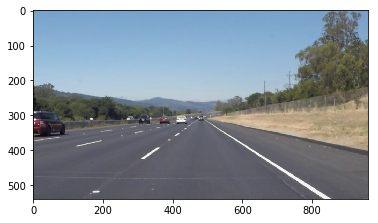

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['frame2.jpg',
 'frame3.jpg',
 'frame4.jpg',
 'frame5.jpg',
 'frame6.jpg',
 'frame7.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

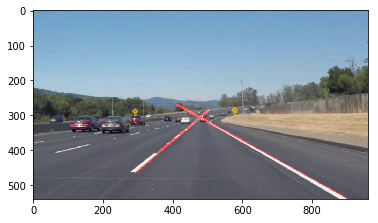

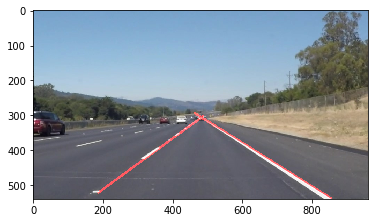

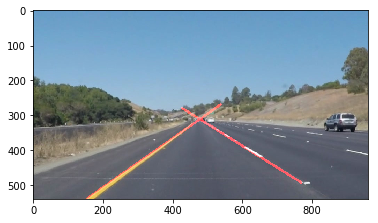

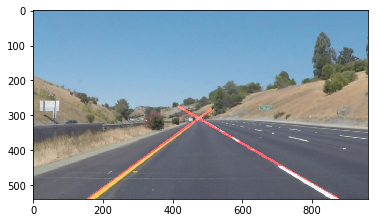

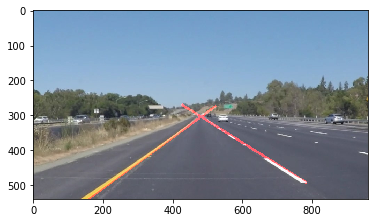

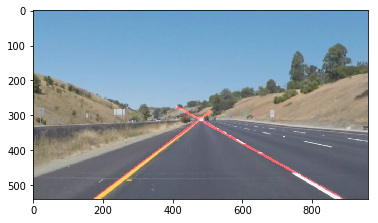

In [11]:
def filter_low_slope(lines):
    result = []
    
    if lines is None:
        return np.empty([0,1,4])

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if math.fabs(slope) < math.tan(20.0 * math.pi / 180.0):
                # Skip lines with slope below 20 degrees
                continue
            else:
                result.append(line)

    return np.array(result)


# Choose the longest left and right line
def find_left_right(lines):
    left_lane = [0, 0, 0, 0]
    left_lane_len = 0
    right_lane = [0, 0, 0, 0]
    right_lane_len = 0

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)

        line_len = (x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1)
        if slope > 0:
            if line_len > right_lane_len:
                right_lane_len = line_len
                right_lane = line
        else:
            if line_len > left_lane_len:
                left_lane_len = line_len
                left_lane = line

    result = []
    if right_lane_len > 0:
        result.append(right_lane)
    if left_lane_len > 0:
        result.append(left_lane)

    return np.array(result)

def extend_lines_to_border(lines, xsize, ysize):
    if lines is None:
        return np.empty([0,1,4])
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            b = y1 - slope * x1
            xborder = (ysize - b) / slope
            if y2 > y1:
                line[0, 3] = ysize
                line[0, 2] = xborder
            else:
                line[0, 1] = ysize
                line[0, 0] = xborder

    return lines


def draw_poly(img, lines, color=[0, 255, 0]):
    if lines is None:
        return
    pts = lines.reshape((-1, 1, 2))
    cv2.fillConvexPoly(img, pts, color)
    
def cut_lines(lines, xsize, ysize):
    if lines.shape[0] != 2:
        # Can work only with exactly two lines
        return np.empty([0,1,4])

    # find intersection point
    lineA = np.polyfit((lines[0][0][0], lines[0][0][2]), (lines[0][0][1], lines[0][0][3]), 1)
    lineB = np.polyfit((lines[1][0][0], lines[1][0][2]), (lines[1][0][1], lines[1][0][3]), 1)

    x = (lineB[1] - lineA[1]) / (lineA[0] - lineB[0])
    y = x * lineA[0] + lineA[1]

    cut_y = y + (ysize - y) * 0.1  # Take bottom 90% below the intersection point

    result = []

    result.append(
        [[
            (ysize - lineA[1]) / lineA[0],
            ysize,
            (cut_y - lineA[1]) / lineA[0],
            cut_y
        ]]
    )

    result.append(
        [[
            (cut_y - lineB[1]) / lineB[0],
            cut_y,
            (ysize - lineB[1]) / lineB[0],
            ysize,
        ]]
    )

    return np.array(result).astype(int)    

def find_lines(gray, xsize, ysize):
    # Smooth
    blur = gaussian_blur(gray, kernel_size=5)

    # Detect edges
    low_threshold = 50
    high_threshold = 192
    edges = canny(blur, low_threshold, high_threshold)

    # Cut region of interest
    mask_verticles = np.array([[
        (0, ysize),
        (xsize * 0.4, ysize * 0.5),
        (xsize * 0.6, ysize * 0.5),
        (xsize, ysize)
    ]], dtype=np.int32)
    masked_image = region_of_interest(edges, mask_verticles)

    # Find lines
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 40  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = xsize / 5  # minimum number of pixels making up a line
    max_line_gap = xsize / 6
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLineLength=min_line_length,
                            maxLineGap=max_line_gap)

    # Skip those with low slope
    filtered_lines = filter_low_slope(lines)

    # Choose the longest left and right lines 
    filtered_lines = find_left_right(filtered_lines)

    return filtered_lines



def process_image(image):
    xsize = image.shape[1]
    ysize = image.shape[0]

    original_image = np.copy(image)

    # Convert to grayscale
    gray = grayscale(image)

    # Smooth
    blur = gaussian_blur(gray, kernel_size=5)

    # Detect edges
    low_threshold = 50
    high_threshold = 192
    edges = canny(blur, low_threshold, high_threshold)
    

    # Cut region of interest
    mask_verticles = np.array([[
        (0, ysize),
        (xsize * 0.4, ysize * 0.5),
        (xsize * 0.6, ysize * 0.5),
        (xsize, ysize)
    ]], dtype=np.int32)
    masked_image = region_of_interest(edges, mask_verticles)

    # Find lines
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 40  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = xsize / 5  # minimum number of pixels making up a line
    max_line_gap = xsize / 6
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLineLength=min_line_length,
                            maxLineGap=max_line_gap)

    # Choose the longest left and right lines ignoring those with low slope (tan < 0.3)
    filtered_lines = filter_low_slope(lines)

    filtered_lines = find_left_right(filtered_lines)

    lane_image = np.zeros((ysize, xsize, 3), dtype=np.uint8)
    draw_lines(lane_image, filtered_lines, thickness=5)

    result = weighted_img(original_image, lane_image)
    return result


def pipeline(image_name):
    image = mpimg.imread(image_name)

    result = process_image(image)

    if not os.path.exists('test_images_output'):
        os.makedirs('test_images_output')

    output_name = 'test_images_output/' + os.path.basename(image_name)
    
    mpimg.imsave(output_name, result, format="jpg")
    
    plt.imshow(result)
    plt.show()

pipeline("test_images/solidWhiteCurve.jpg")
pipeline("test_images/solidWhiteRight.jpg")
pipeline("test_images/solidYellowCurve.jpg")
pipeline("test_images/solidYellowCurve2.jpg")
pipeline("test_images/solidYellowLeft.jpg")
pipeline("test_images/whiteCarLaneSwitch.jpg")

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    xsize = image.shape[1]
    ysize = image.shape[0]

    original_image = np.copy(image)

    # Convert to grayscale
    gray = grayscale(image)

    r, g, b = cv2.split(image) # split BGR to Blue, Green and Red channels.

    test_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    h, l, s = cv2.split(test_image)

    lines_gray = find_lines(gray, xsize, ysize)
    lines_b = find_lines(r, xsize, ysize)
    lines_s = find_lines(s, xsize, ysize)

    # Find the best color space
    # Try to use gray channel first. If no lines found, fallback to G channel of RGB, then fallbach to S channel of HLS
    if lines_gray.shape[0] >= 2:
        lines = lines_gray
    elif lines_b.shape[0] >= 2:
        lines = lines_b
    else:
        lines = lines_s

    lane_image = np.zeros((ysize, xsize, 3), dtype=np.uint8)

    lane = extend_lines_to_border(lines, xsize, ysize)
    nice_lane = cut_lines(lane, xsize, ysize)
    
    if nice_lane.shape[0] == 2:
        # Both left and right lines are found
        #draw_poly(lane_image, nice_lane)
        draw_lines(lane_image, nice_lane, color=[0, 255, 0], thickness=15)
    else:
        # None or only one line found. Draw what we have
        draw_lines(lane_image, lane, color=[0, 255, 0], thickness=15)
    

    result = weighted_img(original_image, lane_image, 0.4, 1)

    return result

Let's try the one with the solid white lane on the right first ...

In [22]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:07<00:00, 31.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [24]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:24<00:00, 27.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 25.5 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Submission

### Pipeline description
My pipeline consisted of 11 steps.
1. Input image is copied and converted to grayscale,
2. Then the image is smoothed with Gaussian blur. Kernel size 5.
3. Edges are found using Canny function from the OpenCV library. 
4. All points outside the region of interest are set to black. As region of interest, I use a trapezium with the height of 50% of the image.
5. I use Hough algorithm to find lines on the masked image form the previous step. During my tests, I noticed that images could have different resolution. Test images are all 960x540, while challenge video has resolution 1280x720. Hard-coding minimum line length would be a bad idea, so I decided to calculate it as image_width / 5.
6. Lines with a low slope (< 20 degrees) cannot be lane lines, so I discard them in function filter_low_slope.
7. I need to find exactly two lines limiting the current lane. In function find_left_right all lines are split in two sets: one with lines going from bottom left corner of the image to the middle and second set of lines going from the right bottom corner. From every set I then select the line with the biggest length.
8. It could happen that in the step above only one line or nothing at all was found. In this case, I retry steps 2-7 using another grayscaling algorithm.
9. Now we have two lines, but they do not end at the bottom of the image. The function extend_lines_to_border extends them downwards to the image border.
10. In addition, the top ends of lines jump up and down folowing the noise in the middle of the image. The function cut_lines cuts those to 90% of distance between bottom border and the line intersection point.
11. Finally, the draw_lines function is used to draw lane lines on the original image.

I decided not to change the draw_lines function because I expect function to do exactly what its name says and do not contain any hidden non-obvious logic. The decision what lines to choose is made in a separate function called find_left_right. Instead of draw_lines you can draw a polygon with my function draw_poly. I personally find polygon more pretty than lines.


### Potential shortcomings
The region of interest is fixed in the bottom 50% of the image. That could be a problem if the car goes downhills and line intersection point will be somewhere close to the top of the image.

The standard grayscaling algorithm does not provide contrast image on the challenge video. Because the wrong lines are detected mostly because of the noise from the green leaves on the blue sky background, my algorithm tries to switch to R channel of RGB that is not so noisy. If that does not help it also tries to find lines in H channel of the HLS color space. That helps a little, but not much. 

### Possible improvements
High contrast grayscale image is critical for the line detection with Canny edge detection and Hough transformation. Some image pre-processing to increase contrast could help.

My code works well on test images, but cannot find lane lines on some video frames. It does not have any memory and analyzes every frame as a separate image. Adding some time smoothing could help to fill small gaps. Taking moving average of last 10 frames will probably provide good results as long as lines were found on  6 of 10 images or more.

In the challenge video, the bottom 10% of the picture do not contain any useful information and can be discarded. In a real car, the camera should be adjusted properly and look on the road and not on the engine hood. If camera position cannot be changed, the bottom area should be excluded from the region of interest.

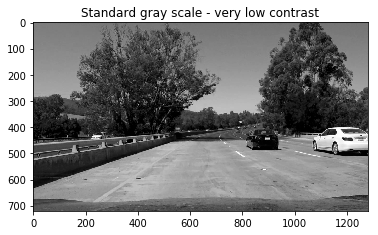

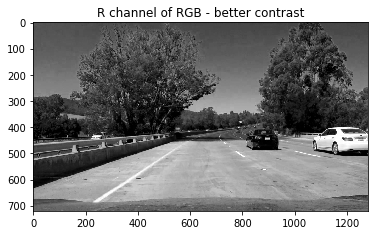

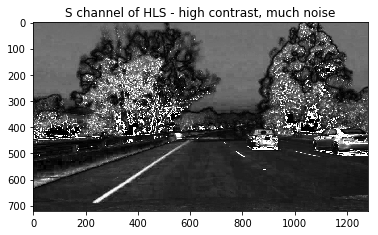

In [26]:
image = mpimg.imread("./test_images/frame5.jpg")
plt.figure()
plt.title("Standard gray scale - very low contrast")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.figure()
plt.title("R channel of RGB - better contrast")
plt.imshow(cv2.split(image)[0], cmap='gray')
plt.show()
plt.title("S channel of HLS - high contrast, much noise")
plt.imshow(cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HLS))[2], cmap='gray')
plt.show()

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [27]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:17<00:00, 14.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 18.7 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))